<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/04_movie_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
%%capture

!pip -q install transformers[sentencepiece]
!pip -q install datasets
!pip install --upgrade accelerate

In [2]:
%%capture

!pip -q install umap-learn

In [46]:
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from datasets import list_datasets, load_dataset

import torch
from torch.nn.functional import cross_entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  display_cm.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

##Dataset

In [27]:
imdb = load_dataset("imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
train_ds = imdb["train"]
train_ds[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


###Class Distribution

In [9]:
# From Datasets to DataFrames
imdb.set_format(type="pandas")
imdb_df = imdb["train"][:]
imdb_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [10]:
def label_int2str(row):
  return imdb["train"].features["label"].int2str(row)

imdb_df["label_name"] = imdb_df["label"].apply(label_int2str)
imdb_df.head()

,text,label,label_name
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,neg
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg
2,If only to avoid making this type of film in t...,0,neg
3,This film was probably inspired by Godard's Ma...,0,neg
4,"Oh, brother...after hearing about this ridicul...",0,neg


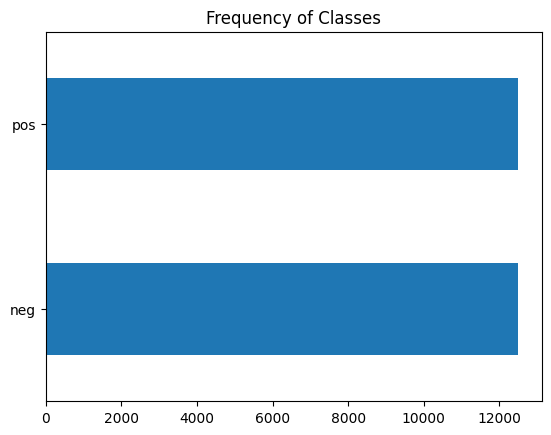

In [11]:
# Looking at the Class Distribution
imdb_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

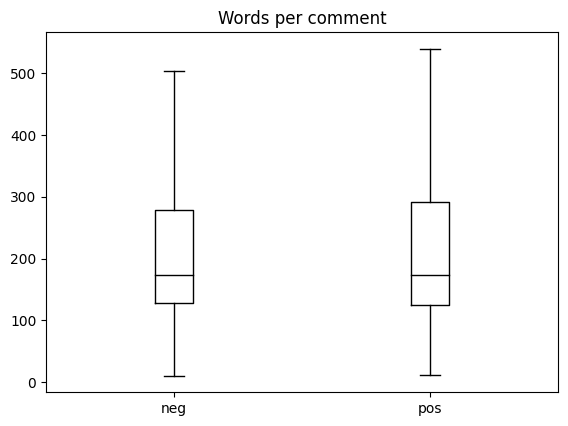

In [12]:
# How Long Are comments?
imdb_df["Words per comment"] = imdb_df["text"].str.split().apply(len)
imdb_df.boxplot("Words per comment", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
# let's go back to our dataset
imdb.reset_format()

##Tokenization

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer.vocab_size

30522

In [16]:
tokenizer.model_max_length

512

In [17]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [18]:
# Tokenizing the Whole Dataset
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

# let’s pass a batch of two examples from the training set
print(tokenize(imdb["train"][:2]))

{'input_ids': [[101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 38

In [ ]:
# we can apply it across all the splits in the corpus
imdb_encoded = imdb.map(tokenize, batched=True, batch_size=None)  # set batch_size=None to apply on the full dataset

In [20]:
# let's see that this operation has added new input_ids and attention_mask columns to the dataset
print(imdb_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


##Feature extraction

In [ ]:
# Using pretrained models
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [22]:
# Extracting the last hidden states
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [23]:
# let's convert the input_ids and attention_mask columns to the "torch" format
imdb_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# now, let's extract the hidden states across all splits in one go
imdb_hidden_state = imdb_encoded.map(extract_hidden_states, batched=True, batch_size=32)

In [25]:
# let's see added a new hidden_state column to our dataset
imdb_hidden_state["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [28]:
# let's create a feature matrix
x_train = np.array(imdb_hidden_state["train"]["hidden_state"])
x_valid = np.array(imdb_hidden_state["test"]["hidden_state"])

y_train = np.array(imdb_hidden_state["train"]["label"])
y_valid = np.array(imdb_hidden_state["test"]["label"])

x_train.shape, x_valid.shape

((25000, 768), (25000, 768))

###Visualizing the training set

In [30]:
# Scale features to [0,1] range
x_scaled = MinMaxScaler().fit_transform(x_train)

# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(x_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-7.111780,-2.131316,0
1,-2.772240,-1.454883,0
2,-1.189590,-0.728424,0
3,-6.876236,-2.097172,0
4,-4.229854,-0.370524,0


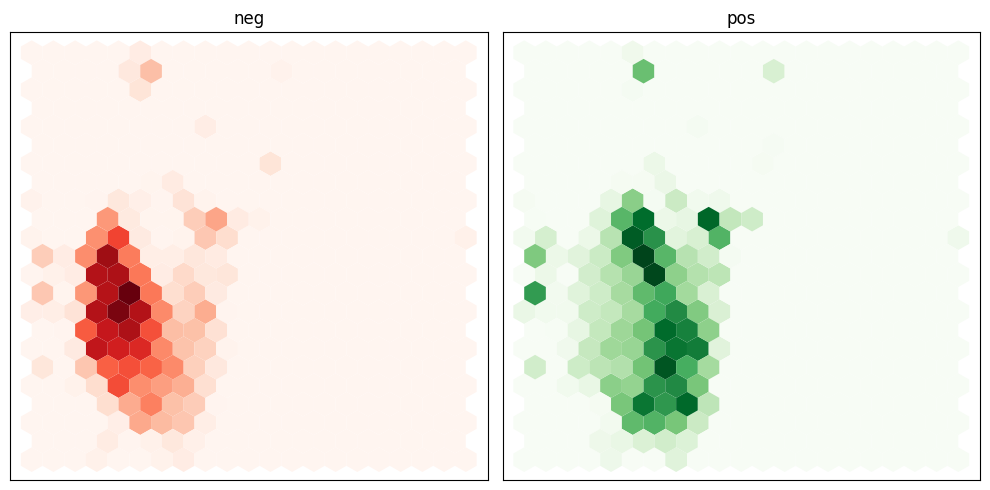

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
cmaps = ["Reds", "Greens"]
labels= imdb["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

###Training Logistic Regression

In [41]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.87568

In [42]:
# let's compare with a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.5

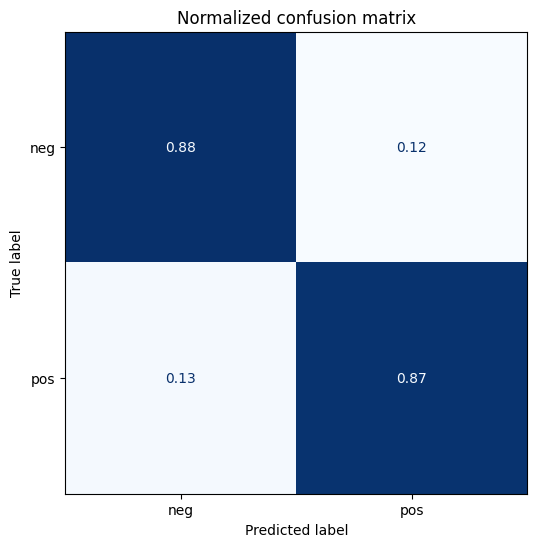

In [45]:
# let's plot confusion matrix
y_preds = lr_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

###Training `RandomForestClassifier`

**Reference**:

[Random Forest Classifier Tutorial](https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial)

In [53]:
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=100)
rf_clf.fit(x_train, y_train)
rf_clf.score(x_valid, y_valid)

0.82624

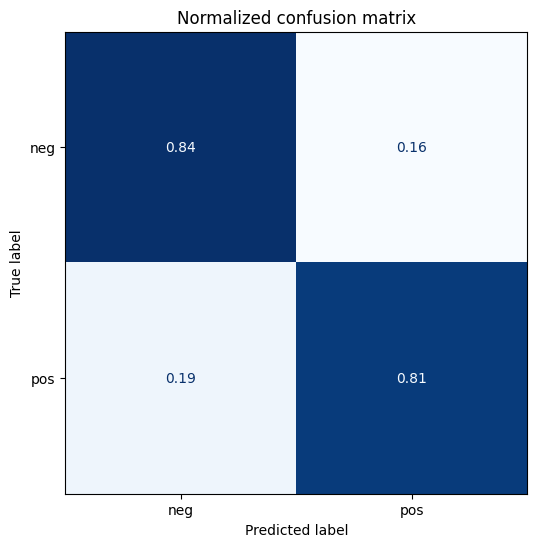

In [54]:
# let's plot confusion matrix
y_preds = rf_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

##Fine-Tuning